# Обнаружение статистически значимых отличий в уровнях экспрессии генов больных раком

Данные для этой задачи взяты из исследования, проведённого в Stanford School of Medicine. В исследовании была предпринята попытка выявить набор генов, которые позволили бы более точно диагностировать возникновение рака груди на самых ранних стадиях.

В эксперименте принимали участие 24 человек, у которых не было рака груди (normal), 25 человек, у которых это заболевание было диагностировано на ранней стадии (early neoplasia), и 23 человека с сильно выраженными симптомами (cancer).

## Libs

In [0]:
from __future__ import division

import numpy as np
import pandas as pd

from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data

In [0]:
gen = pd.read_csv('https://raw.githubusercontent.com/OzmundSedler/100-Days-Of-ML-Code/master/week_13/datasets/gene_high_throughput_sequencing.csv')

In [4]:
gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Columns: 15750 entries, Patient_id to EIF1AY
dtypes: float64(15748), object(2)
memory usage: 8.7+ MB


In [5]:
gen.head()

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,ISG15,AGRN,C1orf159,LOC254099,TTLL10,TNFRSF18,TNFRSF4,SDF4,B3GALT6,FAM132A,UBE2J2,SCNN1D,ACAP3,PUSL1,CPSF3L,GLTPD1,DVL1,MXRA8,AURKAIP1,CCNL2,LOC148413,MRPL20,LOC441869,VWA1,ATAD3C,ATAD3B,ATAD3A,C1orf70,SSU72,LOC643988,...,RENBP,HCFC1,TMEM187,IRAK1,MECP2,TKTL1,FLNA,EMD,RPL10,SNORA70,DNASE1L1,TAZ,ATP6AP1,GDI1,FAM50A,PLXNA3,LAGE3,UBL4A,SLC10A3,FAM3A,G6PD,GAB3,DKC1,MPP1,F8,FUNDC2,MTCP1NB,MTCP1,VBP1,RAB39B,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,STT5425_Breast_001_normal,normal,1.257614,2.408148,13.368622,9.494779,20.880435,12.722017,9.494779,54.349694,26.329928,57.553312,42.455733,6.614939,7.786382,14.283751,18.752091,65.825821,17.471334,14.135344,42.949564,35.946652,50.945017,19.738267,52.172044,34.753563,27.810055,83.303689,59.428091,42.306459,13.209938,20.161089,1.257614,66.621905,3.772842,40.210889,30.278655,14.576032,73.168939,34.692832,...,3.164926,20.369209,5.577156,22.438224,20.981186,1.257614,146.983123,33.074695,4.761250,5.185276,15.282298,24.761483,66.017756,51.888333,40.000566,19.950798,19.306187,26.007591,10.139210,40.105866,43.047651,4.761250,30.624906,9.714340,5.577156,4.761250,10.139210,2.408148,12.214621,3.164926,4.761250,1.257614,1.257614,1.257614,1.257614,1.257614,23.268694,1.257614,1.257614,1.257614
1,STT5427_Breast_023_normal,normal,4.567931,16.602734,42.477752,25.562376,23.221137,11.622386,14.330573,72.445474,39.140813,119.572567,47.367114,4.567931,8.049497,31.421187,19.744990,123.120249,20.615707,16.865244,73.826942,45.474497,63.043023,28.021783,62.483096,60.409871,41.747570,124.715481,128.770634,33.452597,17.876777,28.947097,1.815112,113.503762,1.815112,45.954959,36.946925,15.222429,127.777507,66.567847,...,12.355210,22.255175,9.075559,38.347144,21.245338,1.815112,152.191825,49.097571,8.577883,1.815112,23.965891,30.426817,160.727095,82.216081,60.045184,40.681726,70.040738,44.200859,13.379397,60.045184,72.566645,1.815112,21.451109,6.199787,1.815112,6.199787,5.445335,3.475674,9.075559,1.815112,6.871902,1.815112,1.815112,1.815112,1.815112,1.815112,10.427023,1.815112,1.815112,1.815112
2,STT5430_Breast_002_normal,normal,2.077597,3.978294,12.863214,13.728915,14.543176,14.141907,6.232790,57.011005,48.144685,55.579752,41.741942,3.978294,6.232790,24.317644,28.662801,64.494789,14.543176,12.407734,37.531155,32.074035,63.596176,13.303109,42.016789,26.142516,22.853562,76.118706,56.095106,40.053273,13.303109,20.461953,2.077597,58.702060,2.077597,42.153541,30.416278,16.750119,70.137476,35.481715,...,5.228503,20.178729,3.978294,20.741310,22.085154,3.978294,145.308037,27.008755,6.232790,7.096343,16.750119,24.553171,58.702060,46.192467,44.154018,20.178729,13.728915,23.839609,7.865653,37.684188,39.474334,5.228503,38.139602,9.213541,6.232790,2.077597,12.407734,7.096343,10.387983,6.232790,7.096343,2.077597,2.077597,2.077597,2.077597,2.077597,22.344226,2.077597,2.077597,2.077597
3,STT5439_Breast_003_normal,normal,2.066576,8.520713,14.466035,7.823932,8.520713,2.066576,10.870009,53.292034,27.076621,54.454714,35.933084,2.066576,7.823932,24.422935,15.963105,54.245171,10.870009,14.854454,23.227927,27.905160,49.869762,8.520713,31.903907,16.999606,20.631293,34.477366,39.983492,32.784180,10.870009,24.884876,2.066576,53.398778,9.164670,40.125656,21.968009,14.066895,39.983492,28.907458,...,2.066576,13.656094,7.058702,16.661272,7.823932,2.066576,90.135274,17.976444,2.066576,9.164670,13.656094,15.602310,53.611629,24.654987,35.933084,3.957193,6.199729,11.871578,9.164670,32.434938,25.112660,2.066576,5.200770,14.466035,7.823932,7.823932,17.656837,2.066576,17.331337,5.200770,5.200770,2.066576,2.066576,2.066576,2.066576,2.066576,49.295538,2.066576,2.066576,2.066576
4,STT5441_Breast_004_normal,normal,2.613616,3.434965,12.682222,10.543189,26.688686,12.484822,1.364917,67.140393,35.896701,48.134682,46.507417,7.179340,8.151497,23.096282,29.007823,78.309425,16.586217,18.698195,42.135928,39.393867,65.111910,15.819691,60.974762,27.872385,38.0466

In [6]:
gen.describe()

,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,ISG15,AGRN,C1orf159,LOC254099,TTLL10,TNFRSF18,TNFRSF4,SDF4,B3GALT6,FAM132A,UBE2J2,SCNN1D,ACAP3,PUSL1,CPSF3L,GLTPD1,DVL1,MXRA8,AURKAIP1,CCNL2,LOC148413,MRPL20,LOC441869,VWA1,ATAD3C,ATAD3B,ATAD3A,C1orf70,SSU72,LOC643988,MIB2,CDK11B,...,RENBP,HCFC1,TMEM187,IRAK1,MECP2,TKTL1,FLNA,EMD,RPL10,SNORA70,DNASE1L1,TAZ,ATP6AP1,GDI1,FAM50A,PLXNA3,LAGE3,UBL4A,SLC10A3,FAM3A,G6PD,GAB3,DKC1,MPP1,F8,FUNDC2,MTCP1NB,MTCP1,VBP1,RAB39B,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,...,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,2.463922,7.100958,19.056151,15.618688,23.537120,11.303466,8.921396,63.270147,53.906324,70.678573,44.132730,6.863996,7.133241,24.402249,21.599730,90.584359,18.467272,16.407279,49.225992,41.868812,64.161961,22.657771,60.202268,38.453115,33.693438,106.850256,78.240558,43.223566,16.621457,23.688591,2.515930,86.065184,3.315386,44.371910,29.818395,16.433969,91.239076,38.190137,42.170017,2.129519,...,6.726400,16.080263,7.811794,29.578468,17.860670,2.067846,147.192269,40.983353,5.914062,2.297615,20.434302,30.687594,98.692178,70.602700,54.964073,29.464370,28.938495,31.763734,11.316448,46.695620,58.427981,4.385083,17.129693,8.326683,4.394583,5.475966,9.608058,2.893745,9.230803,3.473785,5.563444,2.192029,1.967424,2.181360,1.729308,1.980733,16.834075,1.825827,2.287380,1.756827
std,1.413687,4.164703,9.287753,4.664146,4.475294,4.055122,3.270713,13.792140,45.635498,21.326237,8.586310,3.116483,2.399742,7.971994,5.786976,17.514023,5.681863,4.219674,10.838989,9.616390,12.107147,7.679158,14.104752,9.298811,7.568479,33.260300,19.146621,7.142939,5.869024,5.320249,1.280790,22.514216,1.768537,8.633568,6.400126,4.305355,21.908707,12.619081,9.671748,0.975237,...,2.870912,4.620615,2.407853,12.093753,3.212180,0.984470,30.687413,10.153553,2.724758,1.538366,5.302574,5.967268,25.575599,20.083253,10.885848,8.240218,13.183109,8.161019,2.797116,8.917365,23.302858,1.771014,5.854227,3.494030,2.202238,1.854298,3.371454,1.337895,3.412977,1.557041,2.389789,2.454218,2.047129,2.542652,1.507149,2.230157,7.126802,1.902716,3.185571,1.623151
min,0.833898,1.231043,4.941211,6.395270,8.520713,2.066576,1.364917,42.544976,24.616767,42.631422,29.797286,0.908698,2.263121,13.476542,10.376669,54.245171,8.539396,6.237200,23.227927,21.491710,34.412164,8.070701,19.765422,16.999606,17.329990,26.894555,39.104193,28.289084,6.177970,7.778763,0.833898,44.222179,0.903290,27.282552,19.465185,7.772347,17.781988,12.943755,27.333133,0.853957,...,1.247440,7.304282,1.647070,6.177970,7.823932,0.833898,66.517781,17.713984,1.132213,0.903290,10.376669,15.602310,52.387886,24.654987,32.540931,3.957193,5.074956,8.683531,5.542565,30.089855,19.702524,1.132213,5.200770,1.593890,1.144240,1.647070,1.593890,0.908698,2.244103,0.833898,1.144240,0.853957,0.853957,0.853957,0.833898,0.833898,4.675683,0.833898,0.853957,0.833898
25%,1.284642,3.892403,13.423946,12.574596,21.151624,8.712898,6.213396,53.093627,34.009687,54.202100,38.849896,4.637472,5.375452,18.520181,18.247188,79.553886,14.509019,14.068325,42.650325,35.963864,57.308987,17.261026,51.735753,34.357644,27.736985,81.286945,67.925464,38.508894,12.895992,20.363574,1.422672,66.806639,2.079672,39.819900,25.097567,13.738901,81

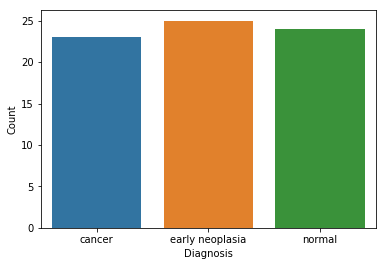

In [7]:
types, cnts = np.unique(gen.Diagnosis.values, return_counts=True)
_ = sns.barplot(types, cnts)
_ = plt.xlabel('Diagnosis')
_ = plt.ylabel('Count')

Ученые провели секвенирование биологического материала испытуемых, чтобы понять, какие из этих генов наиболее активны в клетках больных людей.

Секвенирование — это определение степени активности генов в анализируемом образце с помощью подсчёта количества соответствующей каждому гену РНК.

В данных для этого задания представлена именно эта количественная мера активности каждого из 15748 генов у каждого из 72 человек, принимавших участие в эксперименте.

Нужно будет определить те гены, активность которых у людей в разных стадиях заболевания отличается статистически значимо.

Кроме того, нужно будет оценить не только статистическую, но и практическую значимость этих результатов, которая часто используется в подобных исследованиях.

Диагноз человека содержится в столбце под названием "Diagnosis".

#### Практическая значимость изменения

Цель исследований — найти гены, средняя экспрессия которых отличается не только статистически значимо, но и достаточно сильно. В экспрессионных исследованиях для этого часто используется метрика, которая называется fold change (кратность изменения). Определяется она следующим образом:

Fc(C,T)=T/C при T>C и -T/C при T<C,

где C,T — средние значения экспрессии гена в control и treatment группах соответственно. По сути, fold change показывает, во сколько раз отличаются средние двух выборок.

#### Часть 1: применение t-критерия Стьюдента

В первой части нужно применить критерий Стьюдента для проверки гипотезы о равенстве средних в двух независимых выборках. Применить критерий для каждого гена нужно будет дважды:

* для групп normal (control) и early neoplasia (treatment)
* для групп early neoplasia (control) и cancer (treatment)

В качестве ответа в этой части задания необходимо указать количество статистически значимых отличий, которые мы нашли с помощью t-критерия Стьюдента, то есть число генов, у которых p-value этого теста оказался меньше, чем уровень значимости.

In [0]:
gen_normal = gen[gen.Diagnosis == 'normal']
gen_neoplasia = gen[gen.Diagnosis == 'early neoplasia']
gen_cancer = gen[gen.Diagnosis == 'cancer']

In [0]:
gen_normal_gens_only = gen_normal.drop(['Diagnosis', 'Patient_id'], axis=1)
gen_neoplasia_gens_only = gen_neoplasia.drop(['Diagnosis', 'Patient_id'], axis=1)
gen_cancer_gens_only = gen_cancer.drop(['Diagnosis', 'Patient_id'], axis=1)

In order to use the two-tailed student's test, we need to ensure that the distributions in the samples do not significantly differ from normal ones.

Для того, чтобы использовать двухвыборочный критерий Стьюдента, убедимся, что распределения в выборках существенно не отличаются от нормальных, применив критерий Шапиро-Уилка.

In [10]:
W_stat, p_value = stats.shapiro(gen_normal.drop(['Diagnosis', 'Patient_id'], axis=1))
print (f"Shapiro-Wilk normality test, W-statistic: {W_stat:.4f}, p-value: {p_value:.4f}")

Shapiro-Wilk normality test, W-statistic: 0.6384, p-value: 0.0000


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [11]:
W_stat, p_value = stats.shapiro(gen_neoplasia.drop(['Diagnosis', 'Patient_id'], axis=1))
print (f"Shapiro-Wilk normality test, W-statistic: {W_stat:.4f}, p-value: {p_value:.4f}")

Shapiro-Wilk normality test, W-statistic: 0.6415, p-value: 0.0000


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [12]:
W_stat, p_value = stats.shapiro(gen_cancer.drop(['Diagnosis', 'Patient_id'], axis=1))
print (f"Shapiro-Wilk normality test, W-statistic: {W_stat:.4f}, p-value: {p_value:.4f}")

Shapiro-Wilk normality test, W-statistic: 0.6207, p-value: 0.0000


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Так как среднее значение p-value >> 0.05, то будем применять критерий Стьюдента.

In [0]:
p_value_data = pd.DataFrame(index = gen_neoplasia_gens_only.columns, columns = ['normal-neoplasia', 'neoplasia-cancer'])

In [0]:
for column in gen_normal_gens_only:
  _, p_value_data.loc[column, 'normal-neoplasia'] = stats.ttest_ind(gen_normal_gens_only[column], gen_neoplasia_gens_only[column])
  _,  p_value_data.loc[column, 'neoplasia-cancer'] = stats.ttest_ind(gen_neoplasia_gens_only[column], gen_cancer_gens_only[column])

In [15]:
p_value_data.head()

,normal-neoplasia,neoplasia-cancer
LOC643837,0.690597,0.416764
LOC100130417,3.27055e-05,0.650072
SAMD11,0.0584549,0.0674841
NOC2L,0.825984,0.287644
KLHL17,0.0503907,0.47072


In [16]:
p_value_data[p_value_data['normal-neoplasia'] < 0.05].count()

normal-neoplasia    1583
neoplasia-cancer    1583
dtype: int64

In [17]:
p_value_data[p_value_data['neoplasia-cancer'] < 0.05].count()

normal-neoplasia    3529
neoplasia-cancer    3529
dtype: int64

#### Часть 2: поправка методом Холма

Для этой части задания нам понадобится модуль multitest из statsmodels.

В этой части задания нужно будет применить поправку Холма для получившихся двух наборов достигаемых уровней значимости из предыдущей части. Обратим внимание, что поскольку мы будем делать поправку для каждого из двух наборов p-value отдельно, то проблема, связанная с множественной проверкой останется.

Для того, чтобы ее устранить, достаточно воспользоваться поправкой Бонферрони, то есть использовать уровень значимости 0.05 / 2 вместо 0.05 для дальнейшего уточнения значений p-value c помощью метода Холма.

В качестве ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Холма-Бонферрони. Причем это число нужно ввести с учетом практической значимости: посчитать для каждого значимого изменения fold change и выписать в ответ число таких значимых изменений, абсолютное значение fold change которых больше, чем 1.5.

Обратим внимание, что

* применять поправку на множественную проверку нужно ко всем значениям достигаемых уровней значимости, а не только для тех, которые меньше значения уровня доверия;
* при использовании поправки на уровне значимости 0.025 меняются значения достигаемого уровня значимости, но не меняется значение уровня доверия (то есть для отбора значимых изменений скорректированные значения уровня значимости нужно сравнивать с порогом 0.025, а не 0.05)!

In [0]:
_, p_corrected_1, _, _ = multipletests(p_value_data['normal-neoplasia'], alpha = 0.025, method='holm')
_, p_corrected_2, _, _ = multipletests(p_value_data['neoplasia-cancer'], alpha = 0.025, method='holm')

In [0]:
p_value_data['normal-neoplasia_corrected'] = p_corrected_1
p_value_data['neoplasia-cancer_corrected'] = p_corrected_2

In [20]:
p_value_data.head()

,normal-neoplasia,neoplasia-cancer,normal-neoplasia_corrected,neoplasia-cancer_corrected
LOC643837,0.690597,0.416764,1,1
LOC100130417,3.27055e-05,0.650072,0.514589,1
SAMD11,0.0584549,0.0674841,1,1
NOC2L,0.825984,0.287644,1,1
KLHL17,0.0503907,0.47072,1,1


In [21]:
p_value_data[p_value_data['normal-neoplasia_corrected'] < 0.05].count()

normal-neoplasia              4
neoplasia-cancer              4
normal-neoplasia_corrected    4
neoplasia-cancer_corrected    4
dtype: int64

In [22]:
p_value_data[p_value_data['neoplasia-cancer_corrected'] < 0.05].count()

normal-neoplasia              105
neoplasia-cancer              105
normal-neoplasia_corrected    105
neoplasia-cancer_corrected    105
dtype: int64

In [0]:
def fold_change(C, T, limit=1.5):
    '''
    C - control sample
    T - treatment sample
    '''
    if T >= C:
        fc_stat = T / C
    else:
        fc_stat = -C / T
    
    return fc_stat

In [0]:
col = p_value_data.apply(lambda row: fold_change(row['neoplasia-cancer_corrected'], row['normal-neoplasia_corrected']), axis=1)

In [0]:
p_value_data = p_value_data.assign(**{'fold_change': col.values})

In [26]:
p_value_data.head()

,normal-neoplasia,neoplasia-cancer,normal-neoplasia_corrected,neoplasia-cancer_corrected,fold_change
LOC643837,0.690597,0.416764,1,1,1.0000
LOC100130417,3.27055e-05,0.650072,0.514589,1,-1.9433
SAMD11,0.0584549,0.0674841,1,1,1.0000
NOC2L,0.825984,0.287644,1,1,1.0000
KLHL17,0.0503907,0.47072,1,1,1.0000


In [27]:
p_value_data[(p_value_data['normal-neoplasia_corrected'] < 0.05) & (p_value_data['fold_change'] > 1.5)].count()
p_value_data[(p_value_data['neoplasia-cancer_corrected'] < 0.05) & (p_value_data['fold_change'] > 1.5)].count()

normal-neoplasia              0
neoplasia-cancer              0
normal-neoplasia_corrected    0
neoplasia-cancer_corrected    0
fold_change                   0
dtype: int64

normal-neoplasia              105
neoplasia-cancer              105
normal-neoplasia_corrected    105
neoplasia-cancer_corrected    105
fold_change                   105
dtype: int64

#### Часть 3: поправка методом Бенджамини-Хохберга

Данная часть задания аналогична второй части за исключением того, что нужно будет использовать метод Бенджамини-Хохберга.

Обратим внимание, что методы коррекции, которые контролируют FDR, допускает больше ошибок первого рода и имеют большую мощность, чем методы, контролирующие FWER. Большая мощность означает, что эти методы будут совершать меньше ошибок второго рода (то есть будут лучше улавливать отклонения от H0, когда они есть, и будут чаще отклонять H0, когда отличий нет).

В качестве ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Бенджамини-Хохберга, причем так же, как и во второй части, считать только такие отличия, у которых abs(fold change) > 1.5.

In [0]:
_, p_corrected_1, _, _ = multipletests(p_value_data['normal-neoplasia'], alpha = 0.05, method='fdr_bh')
_, p_corrected_2, _, _ = multipletests(p_value_data['neoplasia-cancer'], alpha = 0.05, method='fdr_bh')

In [0]:
p_value_data['normal-neoplasia_corrected_2'] = p_corrected_1
p_value_data['neoplasia-cancer_corrected_2'] = p_corrected_2

In [30]:
p_value_data[p_value_data['normal-neoplasia_corrected_2'] < 0.05].count()

normal-neoplasia                49
neoplasia-cancer                49
normal-neoplasia_corrected      49
neoplasia-cancer_corrected      49
fold_change                     49
normal-neoplasia_corrected_2    49
neoplasia-cancer_corrected_2    49
dtype: int64

In [31]:
p_value_data[p_value_data['neoplasia-cancer_corrected_2'] < 0.05].count()

normal-neoplasia                1346
neoplasia-cancer                1346
normal-neoplasia_corrected      1346
neoplasia-cancer_corrected      1346
fold_change                     1346
normal-neoplasia_corrected_2    1346
neoplasia-cancer_corrected_2    1346
dtype: int64

In [0]:
col = p_value_data.apply(lambda row: fold_change(row['neoplasia-cancer_corrected_2'], row['normal-neoplasia_corrected_2']), axis=1)

In [0]:
p_value_data = p_value_data.assign(**{'fold_change_2': col.values})

In [34]:
p_value_data[(p_value_data['normal-neoplasia_corrected_2'] < 0.05) & (p_value_data['fold_change_2'] > 1.5)].count()
p_value_data[(p_value_data['neoplasia-cancer_corrected_2'] < 0.05) & (p_value_data['fold_change_2'] > 1.5)].count()

normal-neoplasia                8
neoplasia-cancer                8
normal-neoplasia_corrected      8
neoplasia-cancer_corrected      8
fold_change                     8
normal-neoplasia_corrected_2    8
neoplasia-cancer_corrected_2    8
fold_change_2                   8
dtype: int64

normal-neoplasia                1345
neoplasia-cancer                1345
normal-neoplasia_corrected      1345
neoplasia-cancer_corrected      1345
fold_change                     1345
normal-neoplasia_corrected_2    1345
neoplasia-cancer_corrected_2    1345
fold_change_2                   1345
dtype: int64